# Demo trace amplitude

author: laquitainesteeve@gmail.com

Purpose: describe trace amplitudes

Execution time: 2 min

## Setup

In [20]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath = 'sub-demo-dataset/sub-demo-dataset_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
# proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import amplitude as amp

# configuration of the evoked biophy. simulation at 20 kHz
cfg, param_cfg = get_config("silico_neuropixels", "npx_evoked").values()

# preprocessing parameters
FREQ_MIN = param_cfg["run"]["preprocessing"]["min_filter_freq"]
FREQ_MAX = param_cfg["run"]["preprocessing"]["max_filter_freq"]

# compute parameters
STIM_START = 30000        # arbitrary start of a stimulus (example)
START_AFTER_STIM_MS = 10  # start to plot 10 ms after the stimulus to capture most of its effect which seems delayed
DURATION = 10             # plotted recording duration in ms

# plot parameters
LINEWIDTH_BORD = 0.25
FIGSIZE = (1.3, 5.9)
PLOT_Y_PITCH = 20
LINEWIDTH = 0.5
Y_MAX = PLOT_Y_PITCH * 95

FIG_SIZE = (1.5, 1)
COLOR_NE = [1, 0.49, 0]
cl = dict()
cl["COLOR_NE"] = [1, 0.49, 0] # orange

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame
savefig_cfg = {"transparent":True, "dpi": 300}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-05 12:46:54,537 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-05 12:46:54,642 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [7]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 8
available gpus: False


['/bin/bash: free: command not found']

## (.3s)Load datasets

* first 10 minutes of recordings for speed

In [ ]:
%%time

# download the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
Recording = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")

# load the voltage traces 
traces = Recording.get_traces()

# report info
print("s3_path:", s3_path)
print('\n Recording extractor:', Recording)
print('\n Layers in demo:', np.unique(Recording.get_property('layers')))
print("\n Trace data shape:", traces.shape)

# preprocess
# - compress to int16 (like the Kilosort sorters)
# - apply band-pass filter and common referencing
Recording = spre.astype(Recording, "int16")
Recording = spre.bandpass_filter(
    Recording, freq_min=FREQ_MIN, freq_max=FREQ_MAX
)
Recording = spre.common_reference(
    Recording, reference="global", operator="median"
)

# get traces
traces_ne = Recording.get_traces()

# get sites in cortex
lyrs = ["L5", "L6"]

# get standardized site layer names
site_ly_ne = Recording.get_property("layers")
site_ly_ne = standardize_layers(site_ly_ne)
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]

s3_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3

 Recording extractor: NwbRecordingExtractor: 120 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                       60.00s (1.00 minutes) - float32 dtype - 549.32 MiB
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3

 Layers in demo: ['L5' 'L6']

 Trace data shape: (1200000, 120)

 Sorting extractor: NwbSortingExtractor: 1836 units - 1 segments - 20.0kHz
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3
CPU times: user 16.5 s, sys: 2.56 s, total: 19 s
Wall time: 1min 3s


## Compute

The expected max absolute amplitude is about 387 uV in the full 1-hour trace.

In [18]:
# maximum per site
maxs_ne = np.absolute(traces_ne[:, sites_ne]).max(axis=0)

df3 = pd.DataFrame()
df3["amplitude"] = maxs_ne
df3["layer"] = np.array(site_ly_ne)[sites_ne]
df3["experiment"] = "Biophy. evoked"
df3 = df3.sort_values(by=["layer"])

# stack
plot_data = df3
plot_data = plot_data.sort_values(by=["experiment", "layer"])
display(plot_data)

# report info 
print("Max absolute amplitude:", np.max(np.absolute(traces_ne)))

# unit-test
layers = ["L5", "L6"]
assert df3["layer"].unique().tolist() == layers, "wrong layers"

,amplitude,layer,experiment
59,78,L5,Biophy. evoked
80,80,L5,Biophy. evoked
79,47,L5,Biophy. evoked
78,87,L5,Biophy. evoked
77,350,L5,Biophy. evoked
...,...,...,...
64,50,L6,Biophy. evoked
63,19,L6,Biophy. evoked
62,32,L6,Biophy. evoked
68,21,L6,Biophy. evoked


Max absolute amplitude: 350


## Plot

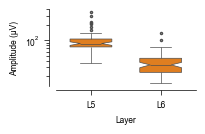

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1));

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="amplitude",
    hue="experiment",
    notch=True,
    hue_order=[
        "Biophy. evoked",
    ],
    palette=[cl["COLOR_NE"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
);

ax.set_yscale("log");

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
);
ax.tick_params(which="both");
ax.yaxis.set_minor_locator(locmin);

# axes
ax.spines[["top", "right"]].set_visible(False);
ax.legend("", frameon=False);

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05));
ax.yaxis.set_ticks_position("left");
ax.spines["left"].set_position(("axes", -0.05));

# ax.legend("", frameon=False)
ax.set_ylabel("Amplitude (\u03bcV)");
ax.set_xlabel("Layer");
ax.set_ylim([0, 400]);

## Statistics

### Peak amplitude changes across layers?

kruskal-Wallis H statistic corresponds to the $\chi^2$ value

Dunn's test

In [30]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record
    

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
print("\n--------------------E--------------------\n")
amp.get_kk_demo(plot_data, "Biophy. evoked")
amp.get_posthoc_dunn_holm_sidak_demo(plot_data, "Biophy. evoked")
m_e = get_medians_and_ci95(plot_data, "Biophy. evoked", "amplitude")  


--------------------E--------------------

H=73.6686553149469, p=9.239447967353078e-18
N_L5 = 52 sites
N_L6 = 68 sites
87.0 $\pm$ 16.245451, 33.5 $\pm$ 4.728365, 


# Are Models and in vivo data the same?

In [6]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_amplitude(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["amplitude"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_amplitude(df, "npx (Marques-Smith)", layer),
        get_amplitude(df, "Biophy. spont.", layer),
        get_amplitude(df, "Biophy. evoked", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_L1 = {count_sites(df, "Biophy. spont.", layer)} sites""")
    print(f"""N_L23 = {count_sites(df, "Biophy. evoked", layer)} sites""")
    print(f"""N_L4 = {count_sites(df, "npx (Marques-Smith)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "npx (Marques-Smith)", layer),
        get_amplitude(plot_data, "Biophy. spont.", layer),
        get_amplitude(plot_data, "Biophy. evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "npx (Marques-Smith)", layer),
        get_amplitude(plot_data, "Biophy. spont.", layer),
        get_amplitude(plot_data, "Biophy. evoked", layer),
        get_amplitude(plot_data, "Synth. (Buccino)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    return df

In [ ]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=12.515296039199686, p=0.0019157462997591108
N_L1 = 16 sites
N_L23 = 16 sites
N_L4 = 10 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.052431,0.001212
Biophy. spont.,0.052431,1.000000,0.132458
Biophy. evoked,0.001212,0.132458,1.000000



------LAYER 2/3:------

H=85.91033419958124, p=2.212116317618949e-19
N_L1 = 47 sites
N_L23 = 47 sites
N_L4 = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,2.453787e-12,3.823039e-18
Biophy. spont.,2.453787e-12,1.000000e+00,7.914154e-02
Biophy. evoked,3.823039e-18,7.914154e-02,1.000000e+00



------LAYER 4:------

H=47.92536738298209, p=3.9186700820012786e-11
N_L1 = 19 sites
N_L23 = 19 sites
N_L4 = 34 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,0.000050,9.601794e-11
Biophy. spont.,4.951118e-05,1.000000,3.263891e-02
Biophy. evoked,9.601794e-11,0.032639,1.000000e+00



------LAYER 5:------

H=20.627688036454504, p=3.3170686187525775e-05
N_L1 = 52 sites
N_L23 = 52 sites
N_L4 = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked,Synth. (Buccino)
npx (Marques-Smith),1.000000,0.152261,1.531374e-04,4.194302e-01
Biophy. spont.,0.152261,1.000000,3.165815e-02,3.206240e-03
Biophy. evoked,0.000153,0.031658,1.000000e+00,9.446307e-11
Synth. (Buccino),0.419430,0.003206,9.446307e-11,1.000000e+00



------LAYER 6:------

H=72.44257662980218, p=1.859064070171466e-16
N_L1 = 68 sites
N_L23 = 68 sites
N_L4 = 98 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,5.470375e-15,3.401204e-09
Biophy. spont.,5.470375e-15,1.000000e+00,7.590239e-02
Biophy. evoked,3.401204e-09,7.590239e-02,1.000000e+00


In [7]:
len(plot_data[(plot_data["experiment"] == "npx (Marques-Smith)") & (plot_data["layer"] == "L1")])

10

### H3: Do the spont. model and M-S amplitudes differ? OFTEN.

In [ ]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L5")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Synth. (Buccino)", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L6")


layer 1

1 vs. 2, z=132.5, p=0.0050175695888443235, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=27.5, p=8.126699062006951e-22, N_1=42, N_2=47

layer 4

1 vs. 2, z=51.5, p=2.6828587253456053e-08, N_1=34, N_2=19

layer 5

1 vs. 2, z=865.0, p=0.08498806738109696, N_1=42, N_2=52


### H4: Do evoked model and M-S amplitudes differ? YES?

In [19]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L6")


layer 1

1 vs. 2, z=135.5, p=0.002765951238154765, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=15.0, p=3.0111929352181764e-23, N_1=42, N_2=47

layer 4

1 vs. 2, z=11.0, p=3.2764200161103315e-12, N_1=34, N_2=19

layer 5

1 vs. 2, z=503.5, p=4.042023180805806e-06, N_1=42, N_2=52

layer 6

1 vs. 2, z=5223.0, p=1.1067832770163676e-10, N_1=98, N_2=68


## Summary stats

In [10]:
L1_ns = (24-19)/24 * 100
L1_e = (24-17)/24 * 100

L6_ns = (82-36)/82 * 100
L6_e = (82-43)/82 * 100

print("Models median peak amplitude are on average ", np.round(np.mean([L1_ns, L1_e, L6_ns, L6_e]),1), "% lower than Marques-SMith data")


L23_ns = (23-48)/23 * 100
L23_e = (23-65)/23 * 100

L4_ns = (27-62)/27 * 100
L4_e = (27-94)/27 * 100

L5_ns = (87-106)/87 * 100
L5_e = (87-127)/87 * 100
L5_s = (87-89)/87 * 100

print("Models median peak amplitude are on average ", - np.round(np.mean([L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e]),1), "% higher than Marques-SMith data")

Models median peak amplitude are on average  38.4 % lower than Marques-SMith data
Models median peak amplitude are on average  122.8 % higher than Marques-SMith data


In [6]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [8]:
# NEUROPIXELS  ------------------

L1_ns = pc(m_m[0], m_ns[0])
L1_e = pc(m_m[0], m_e[0])

L23_ns = pc(m_m[1], m_ns[1])
L23_e = pc(m_m[1], m_e[1])

L4_ns = pc(m_m[2], m_ns[2])
L4_e = pc(m_m[2], m_e[2])

L5_ns = pc(m_m[3], m_ns[3])
L5_e = pc(m_m[3], m_e[3])

L6_ns = pc(m_m[4], m_ns[4])
L6_e = pc(m_m[4], m_e[4])

# NPX average --------

print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e, L6_ns, L6_e]),1),  "% Marques-Smith data")

# NPX detailed pattern
print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L6_ns, L6_e]),1), "% Marques-Smith data across L1, L6")

print("Models median noise are on average ", - np.round(np.median([L23_ns, L23_ns, L4_ns, L4_e, L5_ns, L5_e]),1), "% Marques-Smith data, across L4 and L5")

Models median noise are on average  34.1 % Marques-Smith data
Models median noise are on average  -39.6 % Marques-Smith data across L1, L6
Models median noise are on average  113.3 % Marques-Smith data, across L4 and L5
